In [320]:
import math
from operator import itemgetter

import numpy as np
import pandas as pd
from io import StringIO
import graphviz
import pydotplus
from typing import Dict, Tuple

from dython.nominal import associations
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics._classification import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import HTML
from sklearn.tree import export_text
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

# Загрузка и преобразование данных

In [275]:
data = pd.read_csv("datasets/Hotel Reservations.csv")

In [276]:
data.shape

(36275, 19)

In [277]:
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [278]:
cols_to_drop = [
    "Booking_ID",
    "arrival_year",
    "arrival_month"
]
data.drop(cols_to_drop, axis=1, inplace=True)

In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_date                          36275 non-null  int64  
 9   market_segment_type                   36275 non-null  object 
 10  repeated_guest                        36275 non-null  int64  
 11  no_of_previous_

In [280]:
data.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [281]:
# Получаем метки категориальных признаков
cat_features = []
for col in data.columns:
    dt = str(data[col].dtype)
    if dt == "object":
        cat_features.append(col)
cat_features

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'booking_status']

In [282]:
# Функция построения полной матрицы корреляции
def plot_full_corr_matrix(dataset_, nominal_columns_):
    res_corr = associations(
        dataset=dataset_,
        nominal_columns=nominal_columns_,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        title='Полная матрица корреляции',
        clustering=True,
        figsize=(18,18),
        plot=False,
        compute_only=True,
        mark_columns=True,
    )
    corr_matrix = res_corr['corr']
    plt.figure(figsize=(24,16))
    sns.heatmap(
        data=corr_matrix,
        square=True,
        center=0,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        annot=True,
        vmin=-1.0,
        vmax=1.0
    )
    plt.show()

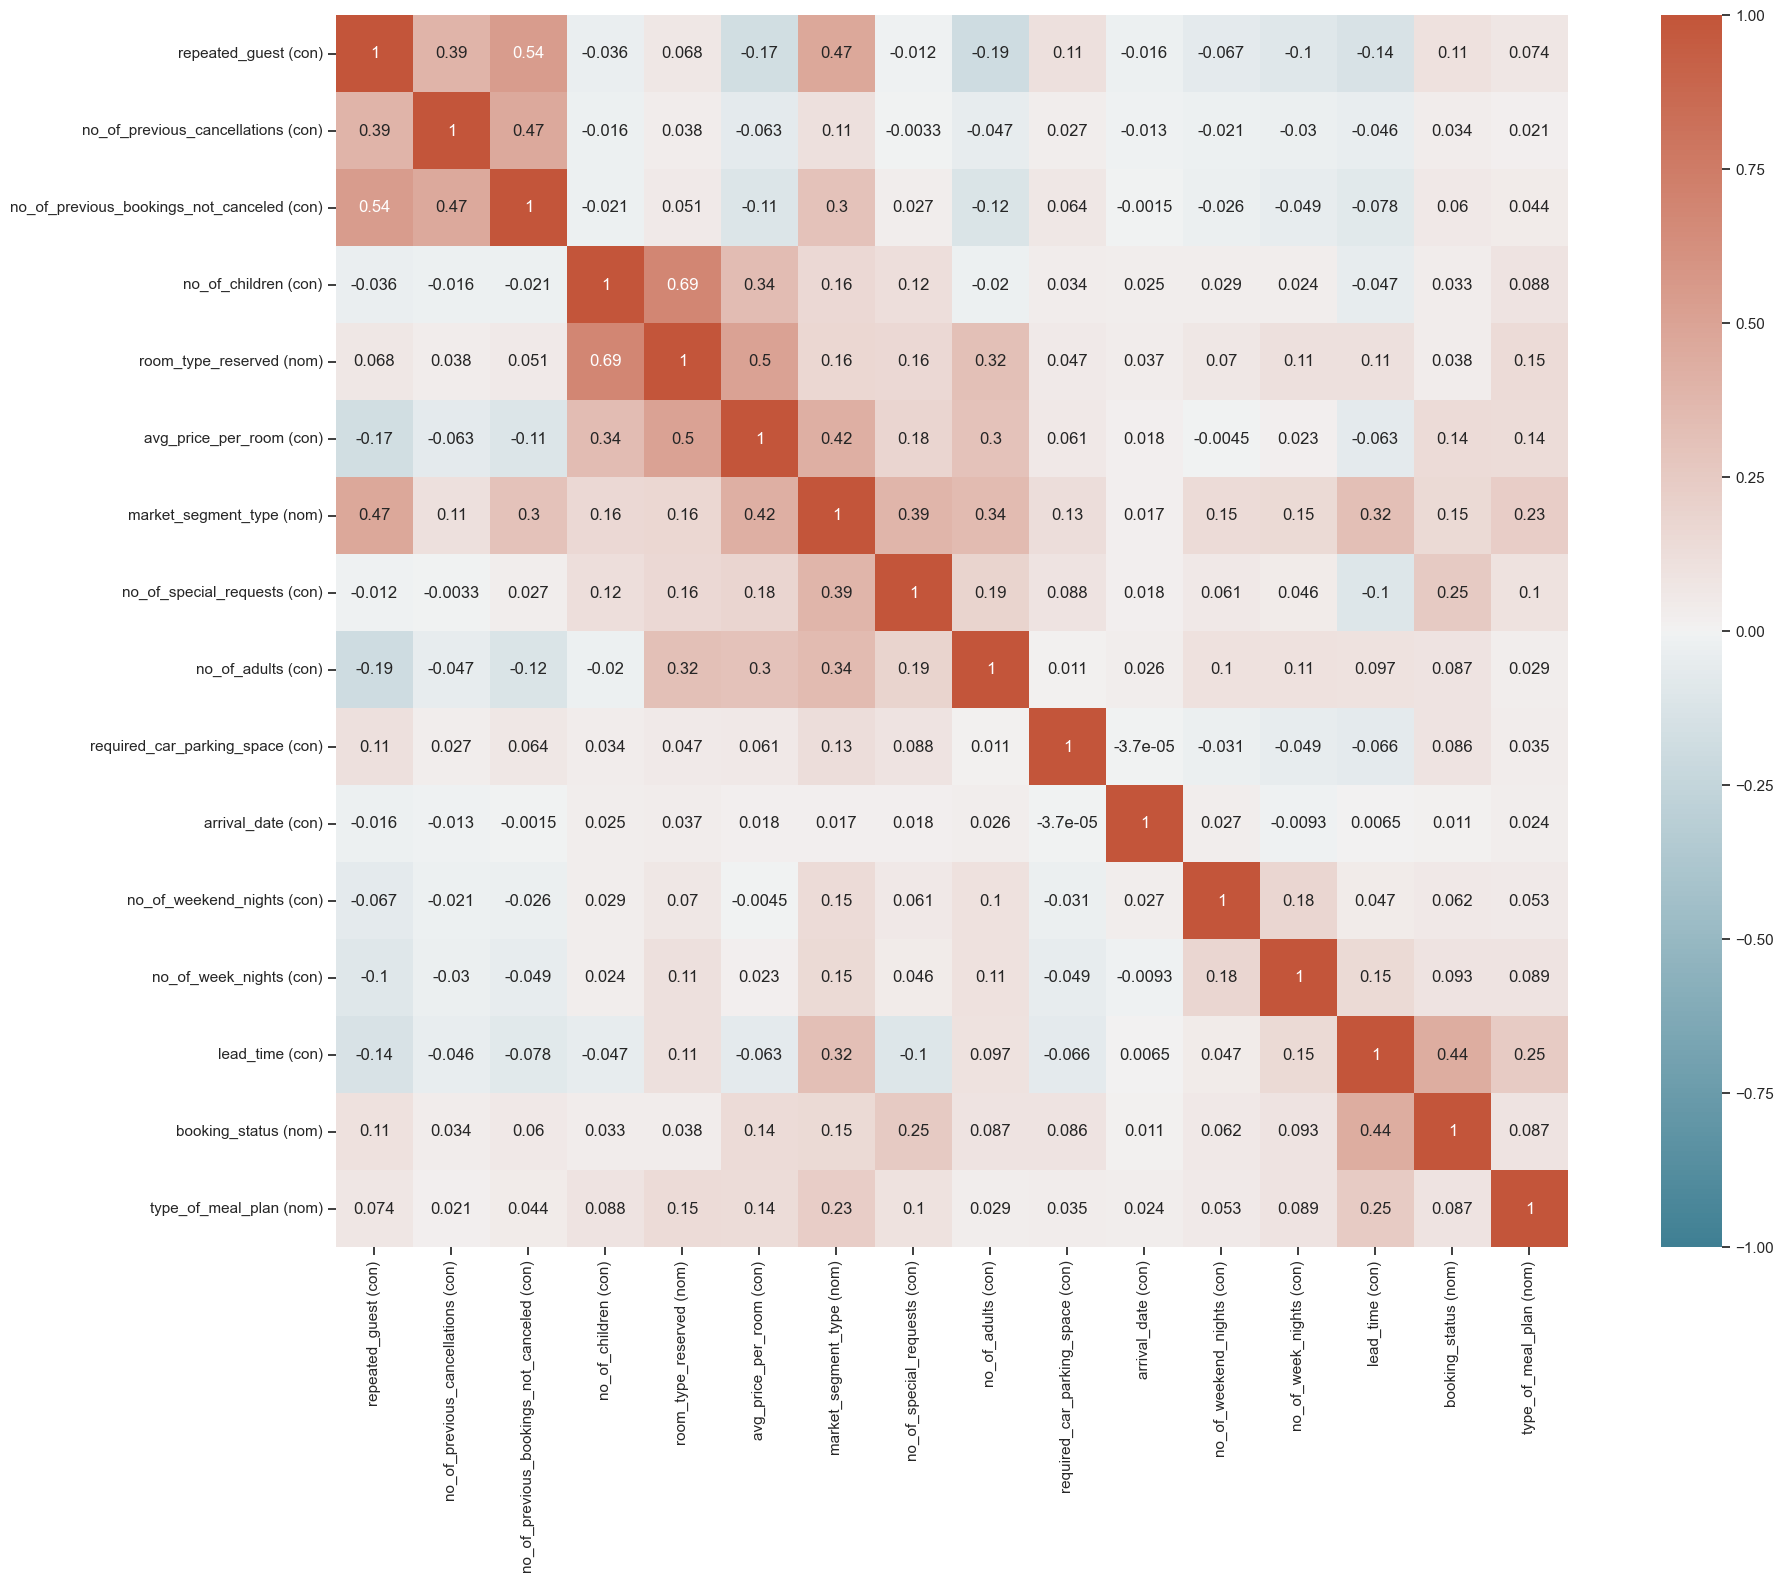

In [283]:
plot_full_corr_matrix(dataset_=data, nominal_columns_=cat_features)

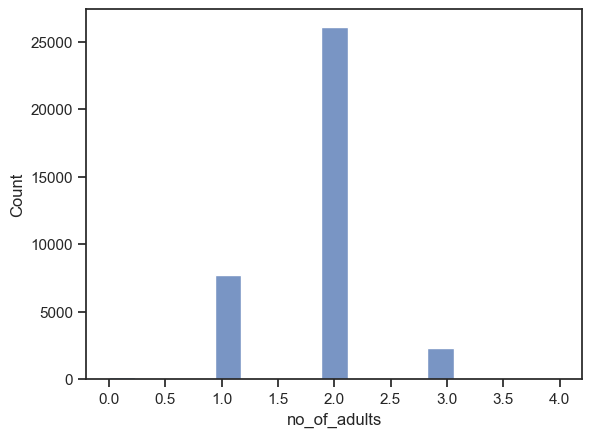

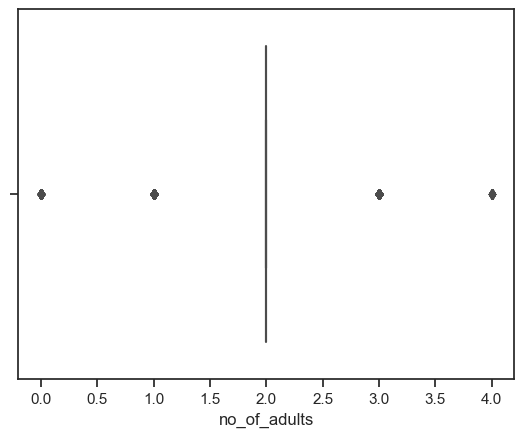

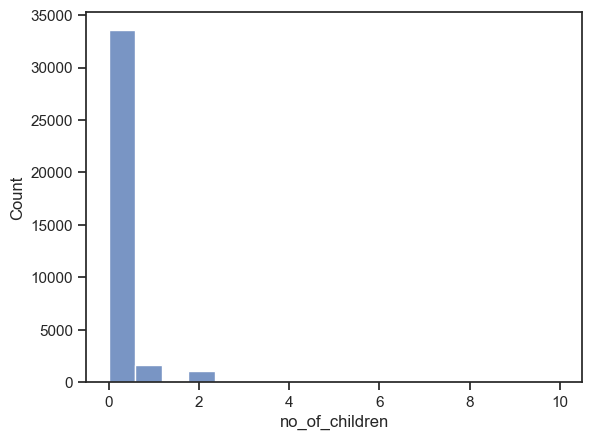

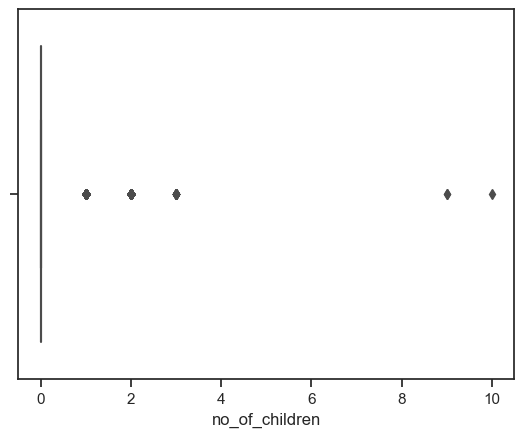

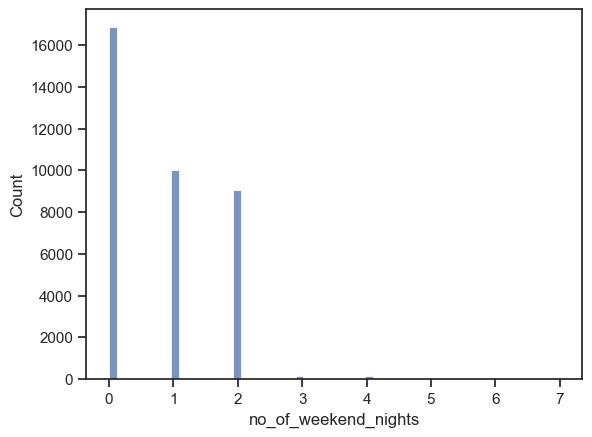

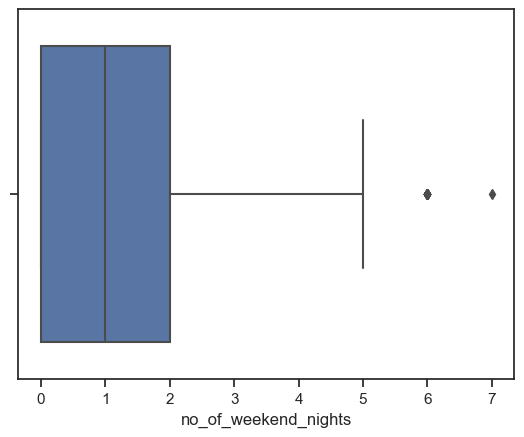

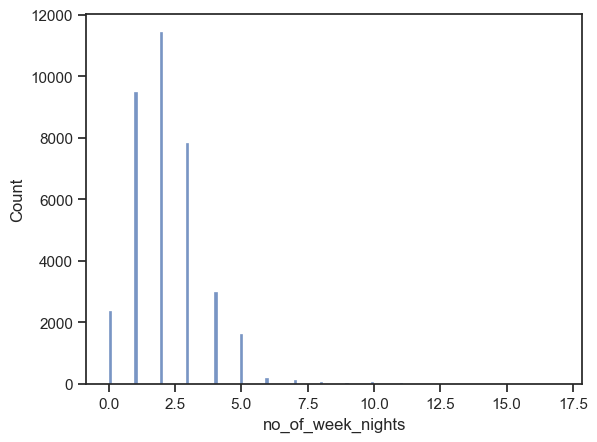

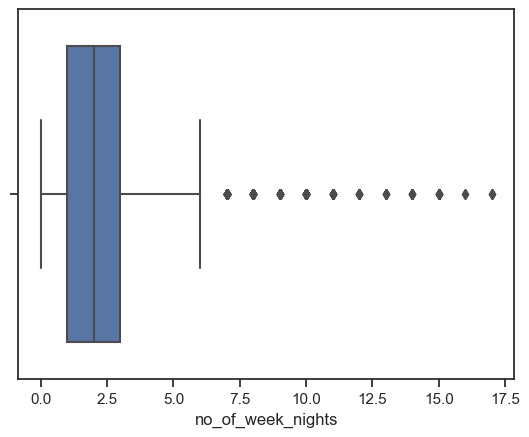

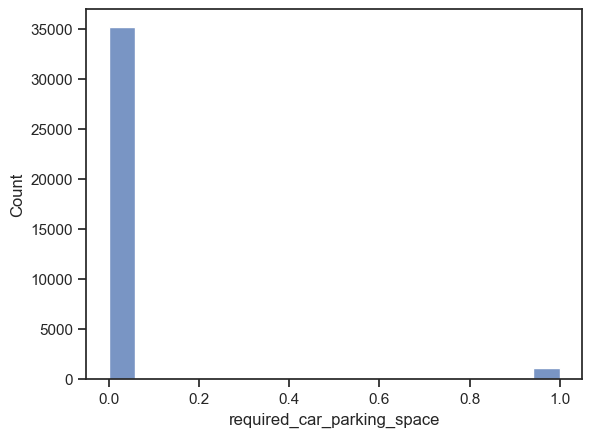

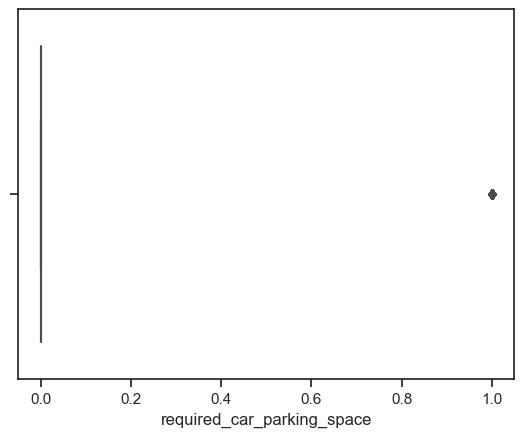

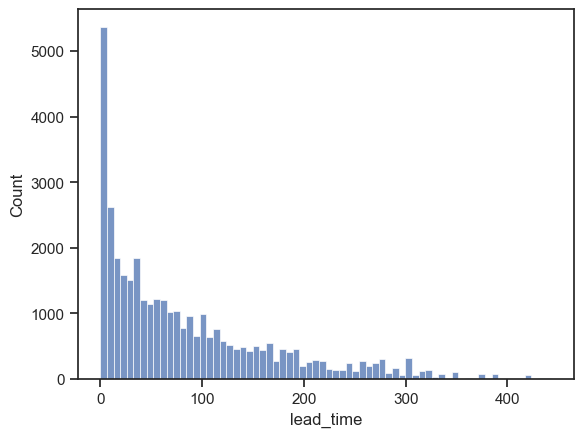

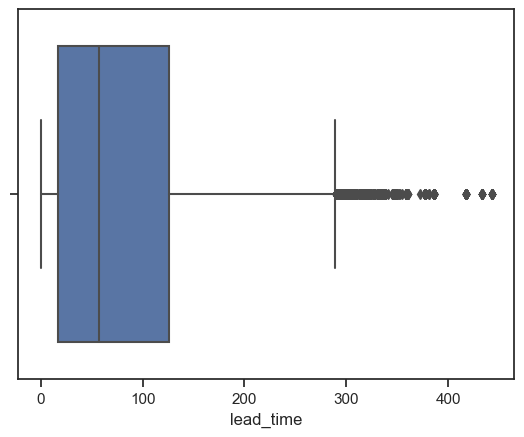

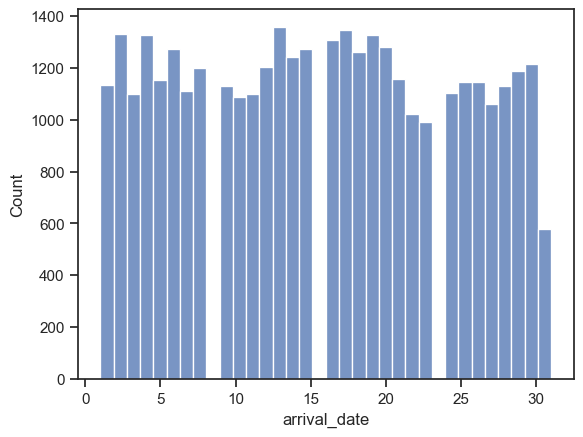

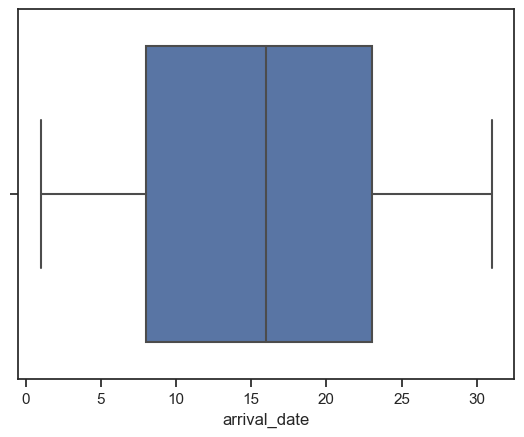

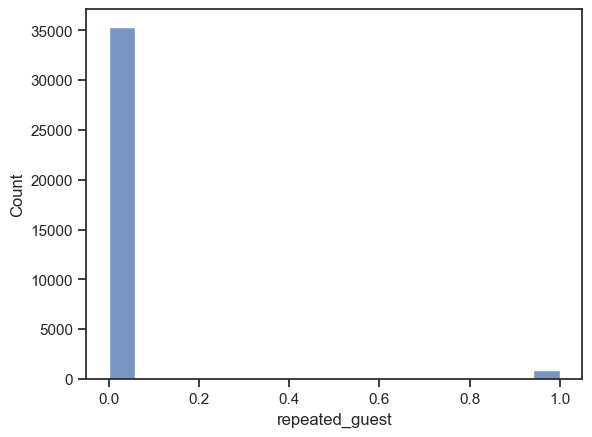

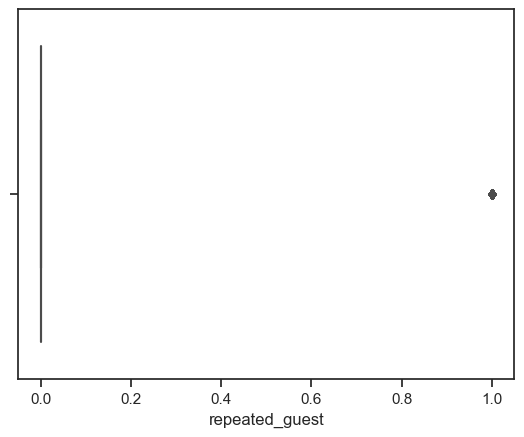

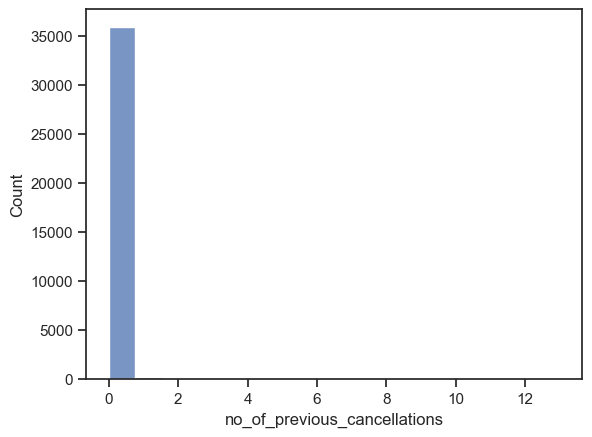

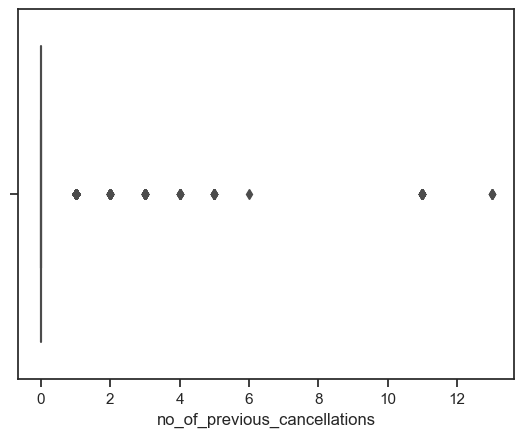

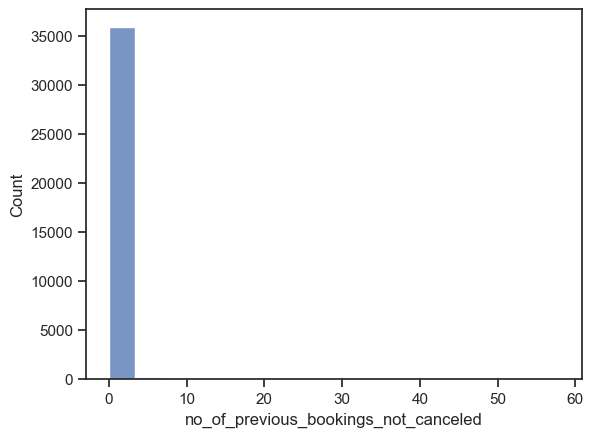

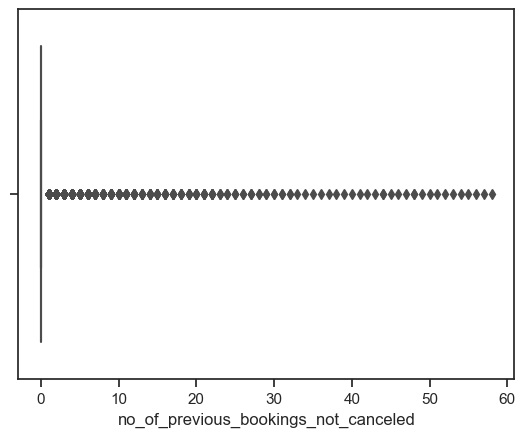

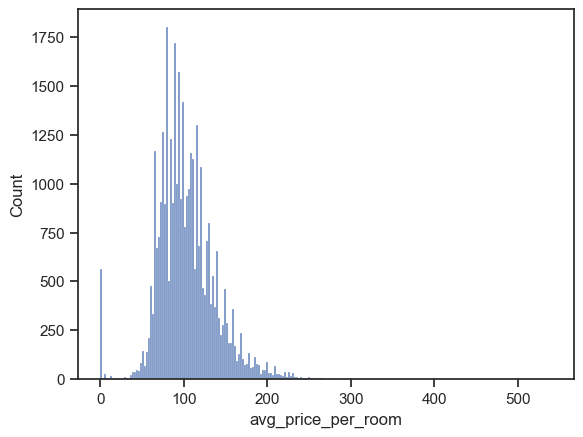

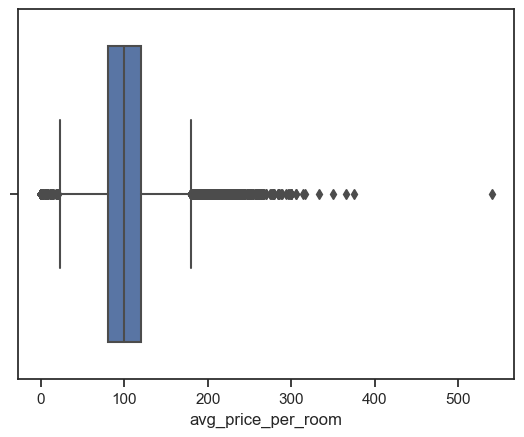

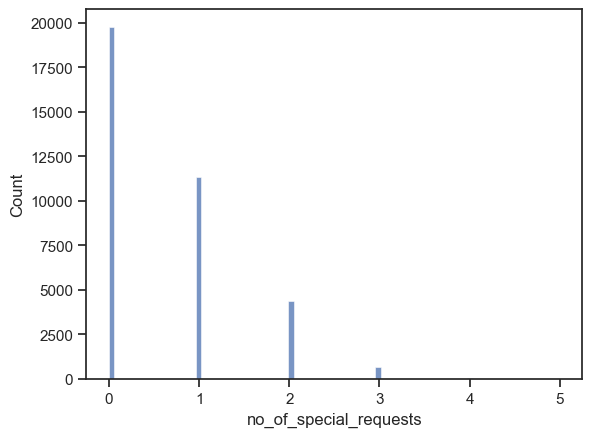

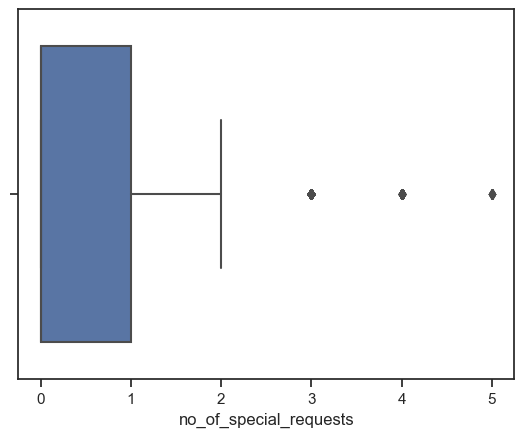

In [284]:
for col in data.drop(cat_features, axis=1, inplace=False):
    sns.histplot(data=data, x=col)
    plt.show()
    sns.boxplot(data=data, x=col)
    plt.show()

In [285]:
# Выбросы
def remove_outliers(df, label):
    q1 = df[label].quantile(0.25)
    q3 = df[label].quantile(0.75)
    iqr = (q3 - q1)
    fil = (df[label] >= q1 - 1.5 * iqr) & (df[label] <= q3 + 1.5 * iqr)
    return df.loc[fil]

In [286]:
col_to_remove_outliers_in = [
    "avg_price_per_room",
    "lead_time"
]

for col in col_to_remove_outliers_in:
    data = remove_outliers(data, col)

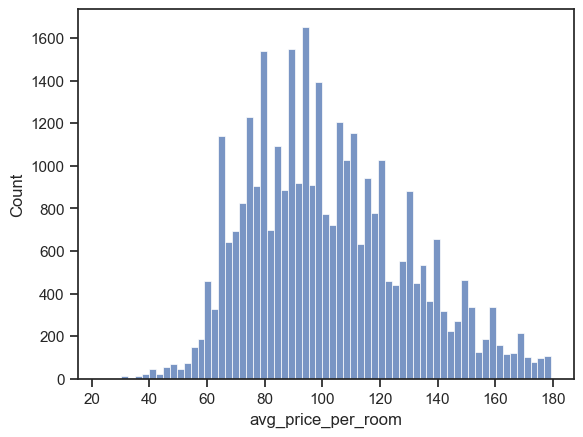

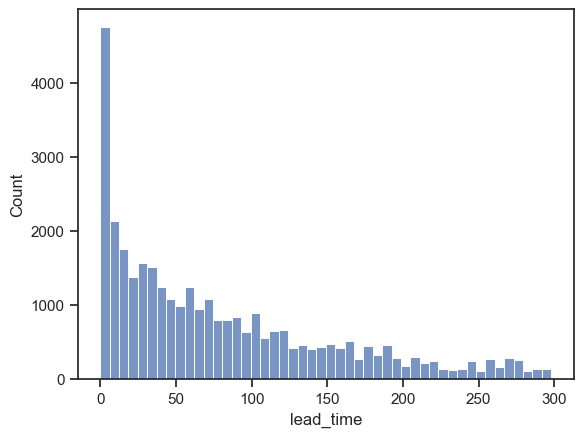

In [287]:
for col in col_to_remove_outliers_in:
    sns.histplot(data=data, x=col)
    plt.show()

In [288]:
# Данные для дерева решений
tree_data = data
tree_data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,3,Online,0,0,0,167.80,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,17,Online,0,0,0,90.95,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,1,Online,0,0,0,98.39,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,21,Online,0,0,0,94.50,0,Canceled


In [289]:
# Масштабирование данных

#data = data.loc[data["lead_time"] > 0]
#data["lead_time"] = data["lead_time"].map(lambda x: math.log(x))
#data

In [290]:
#plot_full_corr_matrix(dataset_=data, nominal_columns_=cat_features)

In [291]:
sc1 = MinMaxScaler()
sc2 = StandardScaler()

for col in data.drop(cat_features, axis=1, inplace=False):
    data[col] = sc2.fit_transform(data[[col]])

In [292]:
#data["avg_price_per_room"] = sc2.fit_transform(data[["avg_price_per_room"]])

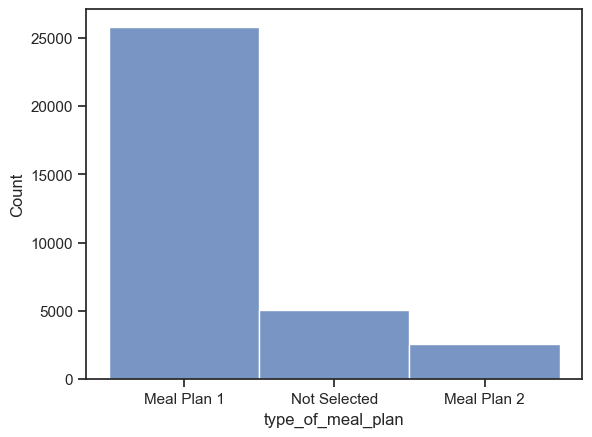

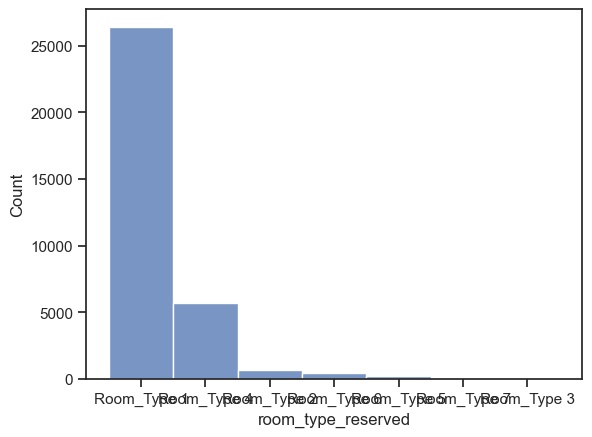

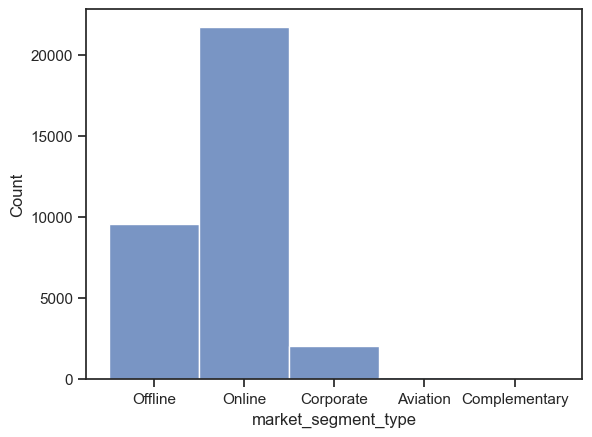

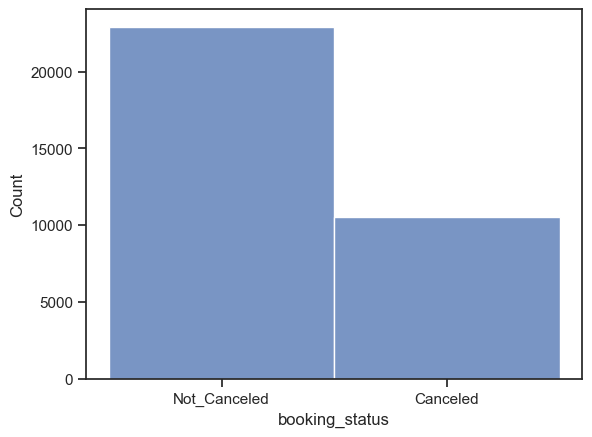

In [293]:
for col in cat_features:
    sns.histplot(data=data, x=data[col])
    plt.show()

In [294]:
# Кодирование признаков
data["booking_status"] = LabelEncoder().fit_transform(data["booking_status"])
cat_features.remove("booking_status")
data = pd.get_dummies(data=data, columns=cat_features)
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,0.305724,-0.234121,0.199405,-0.155487,-0.176237,1.944130,-1.550336,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,1,0
1,0.305724,-0.234121,1.342542,0.549514,-0.176237,-0.995394,-1.093144,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1
2,-1.634373,-0.234121,1.342542,-0.860488,-0.176237,-1.049084,1.421412,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1
3,0.305724,-0.234121,-0.943732,-0.155487,-0.176237,1.769638,0.507028,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1
4,0.305724,-0.234121,0.199405,-0.860488,-0.176237,-0.418227,-0.521654,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2.245820,-0.234121,1.342542,2.664518,-0.176237,0.078405,-1.436038,-0.155599,-0.060415,-0.08089,...,0,1,0,0,0,0,0,0,0,1
36271,0.305724,-0.234121,0.199405,0.549514,-0.176237,1.997820,0.164134,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1
36272,0.305724,-0.234121,1.342542,2.664518,-0.176237,0.924021,-1.664635,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1
36273,0.305724,-0.234121,-0.943732,0.549514,-0.176237,-0.216890,0.621326,-0.155599,-0.060415,-0.08089,...,0,0,0,0,0,0,0,0,0,1


# Построение моделей

### *Логистическая регрессия*

In [295]:
# Разбиение на матрицу объекты-признаки и целевой признак (таргет)
X = data.drop("booking_status", axis=1).values
y = data["booking_status"].values
X, y

(array([[ 0.30572376, -0.23412138,  0.19940497, ...,  0.        ,
          1.        ,  0.        ],
        [ 0.30572376, -0.23412138,  1.34254171, ...,  0.        ,
          0.        ,  1.        ],
        [-1.63437268, -0.23412138,  1.34254171, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 0.30572376, -0.23412138,  1.34254171, ...,  0.        ,
          0.        ,  1.        ],
        [ 0.30572376, -0.23412138, -0.94373176, ...,  0.        ,
          0.        ,  1.        ],
        [ 0.30572376, -0.23412138,  0.19940497, ...,  0.        ,
          1.        ,  0.        ]]),
 array([1, 1, 0, ..., 1, 0, 1]))

In [296]:
# Формирование обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 9)

In [297]:
%%time
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
y_pred_test_log_reg = log_reg.predict(X_test)
y_pred_train_log_reg = log_reg.predict(X_train)
print(classification_report(y_train, y_pred_train_log_reg), classification_report(y_test, y_pred_test_log_reg))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      9489
           1       0.83      0.90      0.86     20626

    accuracy                           0.80     30115
   macro avg       0.78      0.74      0.76     30115
weighted avg       0.79      0.80      0.79     30115
               precision    recall  f1-score   support

           0       0.70      0.59      0.64      1061
           1       0.82      0.88      0.85      2286

    accuracy                           0.79      3347
   macro avg       0.76      0.73      0.74      3347
weighted avg       0.78      0.79      0.78      3347

CPU times: total: 906 ms
Wall time: 679 ms


In [298]:
%%time
# Оценка модели с применением кросс-валидации
scores_log_reg = cross_val_score(log_reg, X, y, cv=25)
np.mean(scores_log_reg)

CPU times: total: 17.1 s
Wall time: 11.8 s


0.797738847566006

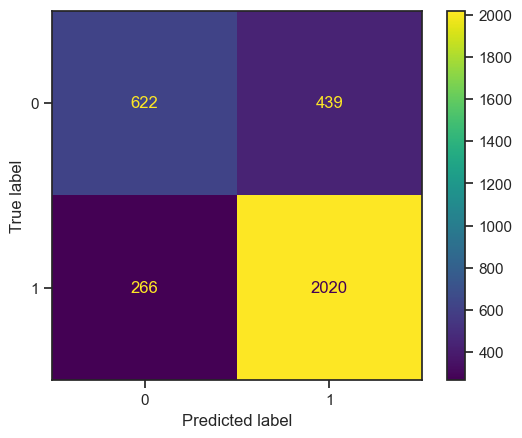

In [299]:
cm_log_reg = confusion_matrix(y_test, y_pred_test_log_reg, labels = log_reg.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_reg
)
display_.plot()

### *Метод опорных векторов SVM*

In [322]:
%%time
svc = SVC(kernel='rbf') # 0.83, 0.84
#svc = SVC(kernel='sigmoid') # 0.69, 0.7
#svc = SVC(kernel='poly') # 0.83, 0.82
svc.fit(X_train, y_train)
y_pred_test_svc = svc.predict(X_test)
y_pred_train_svc = svc.predict(X_train)
print(classification_report(y_train, y_pred_train_svc), classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72      9489
           1       0.85      0.93      0.89     20626

    accuracy                           0.84     30115
   macro avg       0.83      0.79      0.80     30115
weighted avg       0.84      0.84      0.83     30115
               precision    recall  f1-score   support

           0       0.79      0.62      0.69      1061
           1       0.84      0.92      0.88      2286

    accuracy                           0.83      3347
   macro avg       0.81      0.77      0.79      3347
weighted avg       0.82      0.83      0.82      3347

CPU times: total: 1min 5s
Wall time: 1min 5s


In [ ]:
%%time
# Оценка модели с применением кросс-валидации
scores_svc = cross_val_score(svc, X, y, cv=10)
np.mean(scores_svc)

In [302]:
# %%time
# param_grid = {'degree': range(1,6), 'kernel': ['poly']}
# grid = GridSearchCV(SVC(), param_grid, verbose=2, scoring='accuracy')
# grid.fit(X_train, y_train)
# grid.best_params_

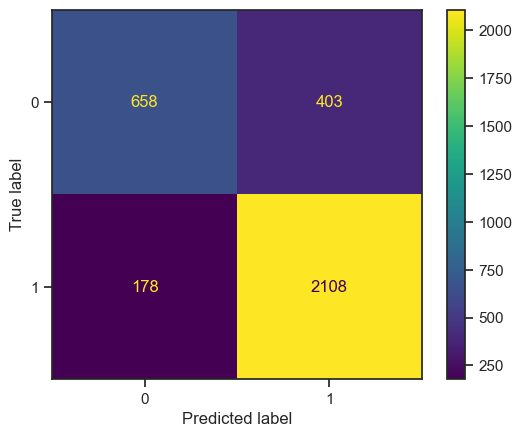

In [325]:
cm_svc = confusion_matrix(y_test, y_pred_test_svc, labels=svc.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_svc
)
display_.plot()

### *Дерево решений*

In [304]:
le = LabelEncoder()
cat_features.append("booking_status")
cat_features

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'booking_status']

In [305]:
for col in cat_features:
    tree_data[col] = le.fit_transform(tree_data[[col]])
    # tree_data[col] = tree_data[col].astype('float64')
tree_data

D:\JetBrains\PyCharm 2021.2.2\PycharmProjects\oad\LR10\.venv\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\JetBrains\PyCharm 2021.2.2\PycharmProjects\oad\LR10\.venv\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\JetBrains\PyCharm 2021.2.2\PycharmProjects\oad\LR10\.venv\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\JetBrains\PyCharm 2021.2.2\PycharmProjects\oad\LR10\.venv\lib\site-packages\sklear

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0.305724,-0.234121,0.199405,-0.155487,0,-0.176237,0,1.944130,-1.550336,3,-0.155599,-0.060415,-0.08089,-1.360739,-0.787898,1
1,0.305724,-0.234121,1.342542,0.549514,2,-0.176237,0,-0.995394,-1.093144,4,-0.155599,-0.060415,-0.08089,0.157187,0.492125,1
2,-1.634373,-0.234121,1.342542,-0.860488,0,-0.176237,0,-1.049084,1.421412,4,-0.155599,-0.060415,-0.08089,-1.542832,-0.787898,0
3,0.305724,-0.234121,-0.943732,-0.155487,0,-0.176237,0,1.769638,0.507028,4,-0.155599,-0.060415,-0.08089,-0.086089,-0.787898,0
4,0.305724,-0.234121,0.199405,-0.860488,2,-0.176237,0,-0.418227,-0.521654,4,-0.155599,-0.060415,-0.08089,-0.286391,-0.787898,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2.245820,-0.234121,1.342542,2.664518,0,-0.176237,3,0.078405,-1.436038,4,-0.155599,-0.060415,-0.08089,2.383091,0.492125,1
36271,0.305724,-0.234121,0.199405,0.549514,0,-0.176237,0,1.997820,0.164134,4,-0.155599,-0.060415,-0.08089,-0.415677,1.772148,0
36272,0.305724,-0.234121,1.342542,2.664518,0,-0.176237,0,0.924021,-1.664635,4,-0.155599,-0.060415,-0.08089,-0.144723,1.772148,1
36273,0.305724,-0.234121,-0.943732,0.549514,2,-0.176237,0,-0.216890,0.621326,4,-0.155599,-0.060415,-0.08089,-0.286391,-0.787898,0


In [306]:
X_tree = tree_data.drop("booking_status", axis=1, inplace=False).values
y_tree = tree_data["booking_status"].values
X_tree, y_tree

(array([[ 0.30572376, -0.23412138,  0.19940497, ..., -0.08089038,
         -1.36073933, -0.78789782],
        [ 0.30572376, -0.23412138,  1.34254171, ..., -0.08089038,
          0.15718712,  0.49212533],
        [-1.63437268, -0.23412138,  1.34254171, ..., -0.08089038,
         -1.54283224, -0.78789782],
        ...,
        [ 0.30572376, -0.23412138,  1.34254171, ..., -0.08089038,
         -0.14472292,  1.77214847],
        [ 0.30572376, -0.23412138, -0.94373176, ..., -0.08089038,
         -0.2863912 , -0.78789782],
        [ 0.30572376, -0.23412138,  0.19940497, ..., -0.08089038,
          2.15984489, -0.78789782]]),
 array([1, 1, 0, ..., 1, 0, 1], dtype=int64))

In [307]:
# Формирование обучающей и тестовой выборки
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size = 0.1, random_state = 9)

In [314]:
tree = DecisionTreeClassifier(random_state=9).fit(X_train_tree, y_train_tree)
y_pred_test_tree = tree.predict(X_test_tree)
y_pred_train_tree = tree.predict(X_train_tree)
print(classification_report(y_train_tree, y_pred_train_tree), classification_report(y_test_tree, y_pred_test_tree))
# при стандартном обучении получаем переобучение

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9489
           1       1.00      0.99      1.00     20626

    accuracy                           0.99     30115
   macro avg       0.99      0.99      0.99     30115
weighted avg       0.99      0.99      0.99     30115
               precision    recall  f1-score   support

           0       0.76      0.77      0.76      1061
           1       0.89      0.89      0.89      2286

    accuracy                           0.85      3347
   macro avg       0.82      0.83      0.83      3347
weighted avg       0.85      0.85      0.85      3347



In [315]:
tree.tree_.max_depth, tree.tree_.node_count

(33, 7735)

In [310]:
params = {
    'max_depth': range(3, 16)
}

In [313]:
%%time
grid_1 = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=9),
    param_grid=params,
    scoring='accuracy',
    cv=20
)
grid_1.fit(X_tree, y_tree)
grid_1.best_params_, grid_1.best_score_

CPU times: total: 18.8 s
Wall time: 19.1 s


({'max_depth': 13}, 0.8657582548323539)

In [317]:
tree_rules = export_text(grid_1.best_estimator_, feature_names=list(tree_data.drop("booking_status", axis=1).columns))
HTML('<pre>' + tree_rules + '</pre>')

In [318]:
def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

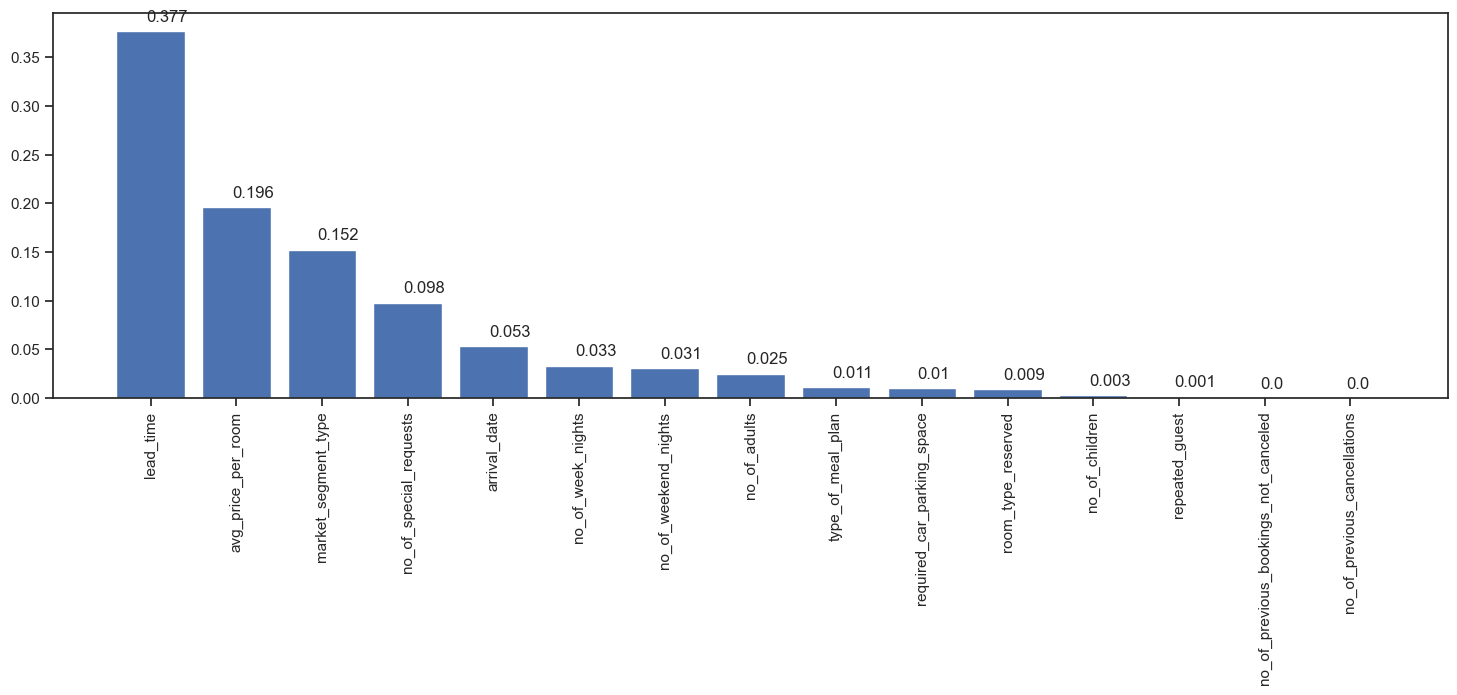

In [321]:
iris_tree_cl_fl, iris_tree_cl_fd = draw_feature_importances(grid_1.best_estimator_, tree_data)

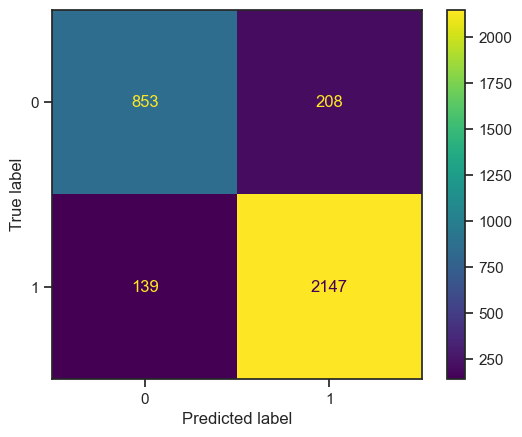

In [332]:
cm_tree = confusion_matrix(y_test_tree, grid_1.best_estimator_.predict(X_test_tree))
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_tree
)
display_.plot()

